In [27]:
import pandas as pd
from sklearn.datasets import load_iris
data = load_iris()
X = data.data
y = data.target
y_bin = label_binarize(y, classes=[0, 1, 2])  # For ROC

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

In [30]:
model_configs = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "grid": {'n_estimators': [50, 100], 'max_depth': [2, 4]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "grid": {'C': [0.1, 1], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "grid": {'C': [0.1, 1], 'solver': ['liblinear', 'lbfgs']}
    }
}

In [31]:
# Evaluation function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='macro'),
        "Recall": recall_score(y_test, y_pred, average='macro'),
        "F1-Score": f1_score(y_test, y_pred, average='macro'),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)}

In [37]:
results = []
conf_matrices = {}
roc_auc_info = {}
# Train, tune, and evaluate
for name, config in model_configs.items():
    base_model = config["model"]
    base_model.fit(X_train, y_train)
    results.append(evaluate_model(name, base_model, X_test, y_test))
    conf_matrices[name] = results[-1]["Confusion Matrix"]
    # Hyperparameter tuning
    if name == "SVM":
        search = RandomizedSearchCV(base_model, config["grid"], n_iter=4, cv=3, random_state=42)
    else:
        search = GridSearchCV(base_model, config["grid"], cv=3)
    search.fit(X_train, y_train)
    tuned_model = search.best_estimator_
    tuned_name = f"{name} (Tuned)"
    results.append(evaluate_model(tuned_name, tuned_model, X_test, y_test))
    conf_matrices[tuned_name] = results[-1]["Confusion Matrix"]

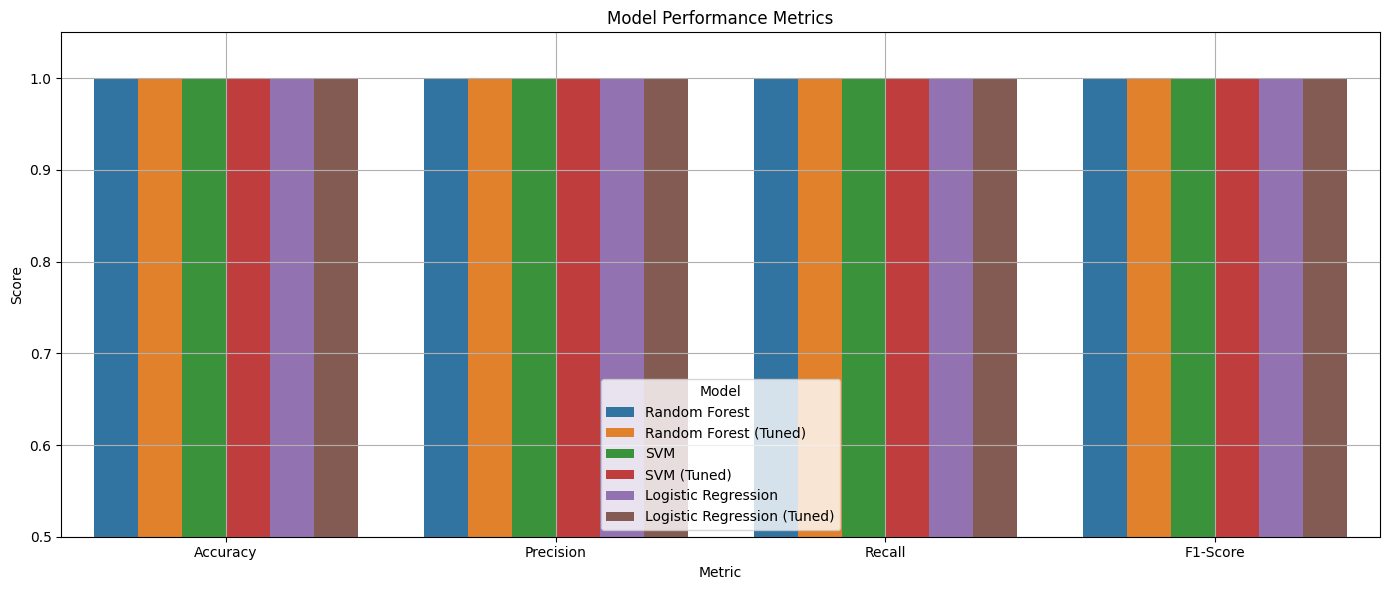

In [38]:
# Metric comparison table
metrics_df = pd.DataFrame(results).drop(columns=["Confusion Matrix"])
melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
# Plot bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=melted, x="Metric", y="Score", hue="Model")
plt.title("Model Performance Metrics")
plt.ylim(0.5, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

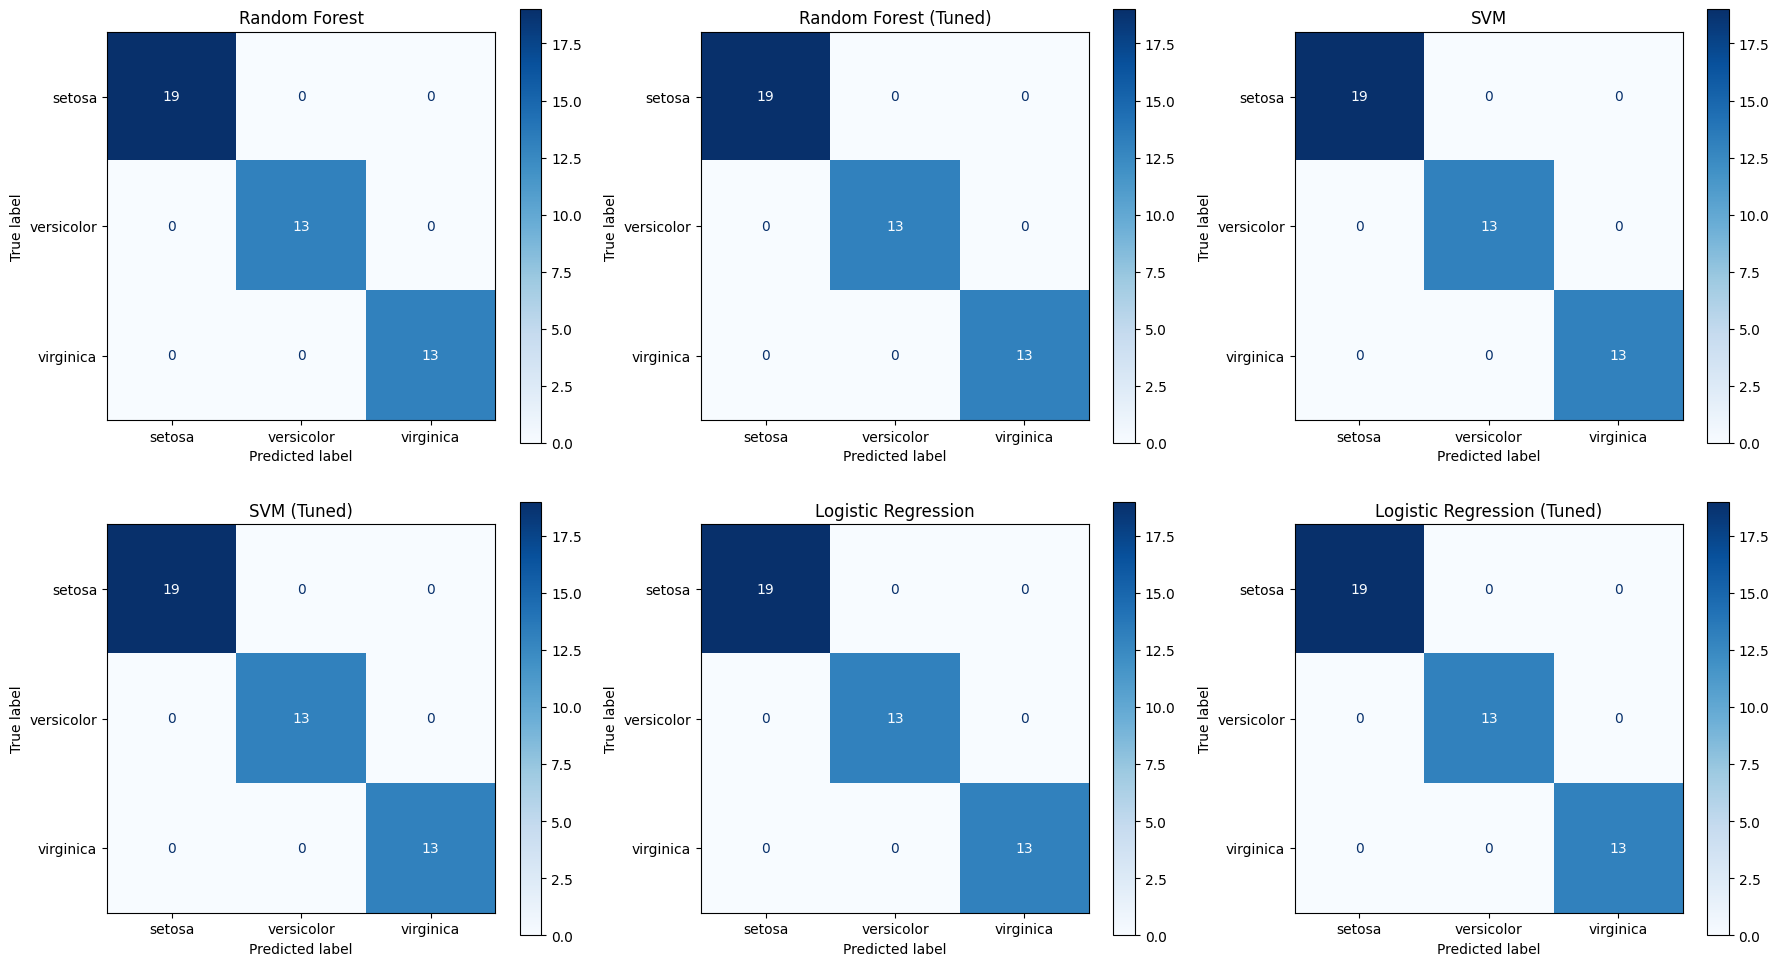

In [39]:
# Confusion matrix plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for ax, (name, cm) in zip(axes, conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
    disp.plot(ax=ax, values_format='d', cmap='Blues')
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [35]:
# ROC Curve with AUC (OneVsRest)
X_train_bin, X_test_bin = X_train, X_test
y_train_bin, y_test_bin = label_binarize(y_train, classes=[0, 1, 2]), label_binarize(y_test, classes=[0, 1, 2])

models_roc = {
    "Logistic Regression": make_pipeline(StandardScaler(), OneVsRestClassifier(LogisticRegression(max_iter=1000))),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier()),
    "SVM": make_pipeline(StandardScaler(), OneVsRestClassifier(SVC(probability=True)))
}

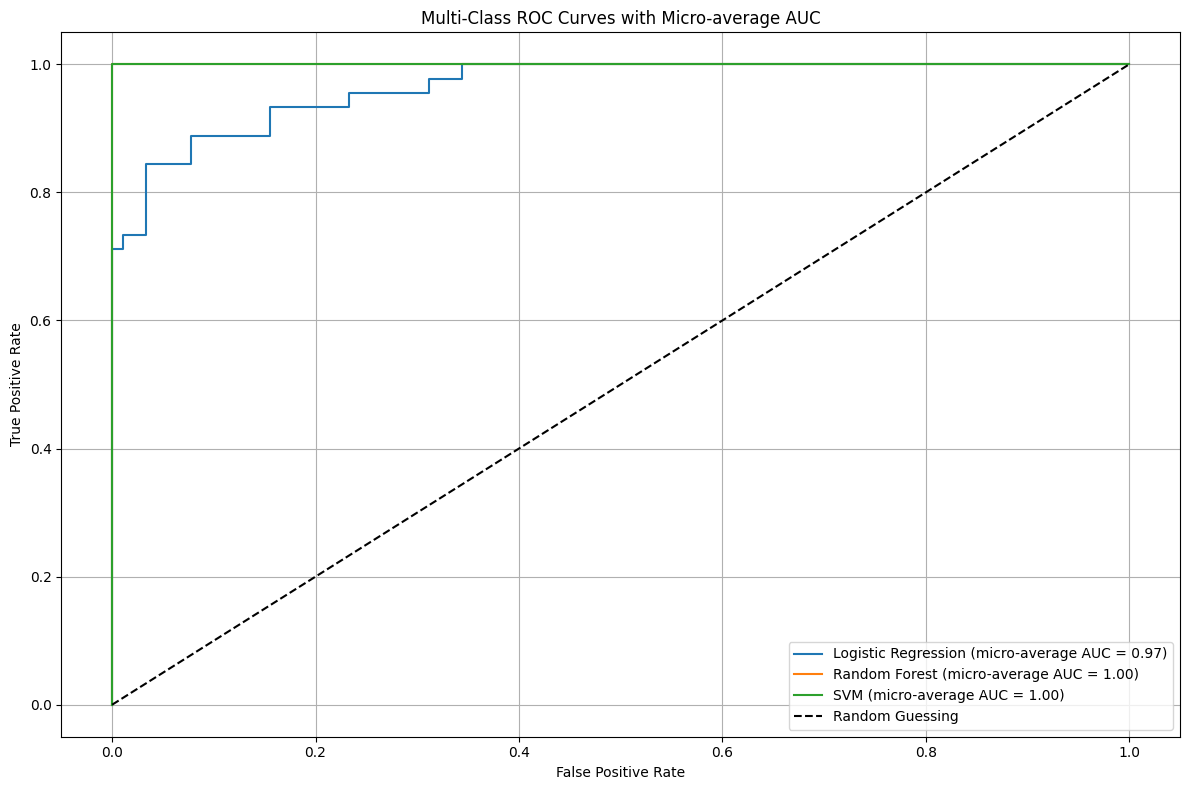

In [40]:
plt.figure(figsize=(12, 8))
for name, model in models_roc.items():
    model.fit(X_train_bin, y_train_bin)
    y_score = model.predict_proba(X_test_bin)
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"], label=f"{name} (micro-average AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves with Micro-average AUC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()